## Summary

Bike sharing demand prediction
data cleaning: one-hot encoding, binary category -> 0,1, extract month & day, check null values
Investigate x & y - may need to filter x , correlations

## Import Libraries

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

from sklearn.neighbors import KNeighborsRegressor
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from statsmodels.stats.stattools import durbin_watson

## Load Dataset

In [2]:
#Read Dataset
bike_df = pd.read_csv('./SeoulBikeData.csv')

In [3]:
bike_df

Date  Rented Bike Count  Hour  Temperature  Humidity  Wind Speed  \
0      1/12/2017                254     0         -5.2        37         2.2   
1      1/12/2017                204     1         -5.5        38         0.8   
2      1/12/2017                173     2         -6.0        39         1.0   
3      1/12/2017                107     3         -6.2        40         0.9   
4      1/12/2017                 78     4         -6.0        36         2.3   
...          ...                ...   ...          ...       ...         ...   
8755  30/11/2018               1003    19          4.2        34         2.6   
8756  30/11/2018                764    20          3.4        37         2.3   
8757  30/11/2018                694    21          2.6        39         0.3   
8758  30/11/2018                712    22          2.1        41         1.0   
8759  30/11/2018                584    23          1.9        43         1.3   

      Visibility  Dew Point Temperature  Solar Radiation  Rainfall  Snowfall  \
0           2000                  -17.6              0.0       0.0       0.0   
1           2000                  -17.6              0.0       0.0       0.0   
2           2000                  -17.7              0.0       0.0       0.0   
3           2000                  -17.6              0.0       0.0       0.0   
4           2000                  -18.6              0.0       0.0       0.0   
...          ...                    ...              ...       ...       ...   
8755        1894                  -10.3              0.0       0.0       0.0   
8756        2000                   -9.9              0.0       0.0       0.0   
8757        1968                   -9.9              0.0       0.0       0.0   
8758        1859                   -9.8              0.0       0.0       0.0   
8759        1909                   -9.3              0.0       0.0       0.0   

     Seasons     Holiday Functioning Day  
0     Winter  No Holiday             Yes  
1     Winter  No Holiday             Yes  
2     Winter  No Holiday             Yes  
3     Winter  No Holiday             Yes  
4     Winter  No Holiday             Yes  
...      ...         ...             ...  
8755  Autumn  No Holiday             Yes  
8756  Autumn  No Holiday             Yes  
8757  Autumn  No Holiday             Yes  
8758  Autumn  No Holiday             Yes  
8759  Autumn  No Holiday             Yes  

[8760 rows x 14 columns]

In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   8760 non-null   object 
 1   Rented Bike Count      8760 non-null   int64  
 2   Hour                   8760 non-null   int64  
 3   Temperature            8760 non-null   float64
 4   Humidity               8760 non-null   int64  
 5   Wind Speed             8760 non-null   float64
 6   Visibility             8760 non-null   int64  
 7   Dew Point Temperature  8760 non-null   float64
 8   Solar Radiation        8760 non-null   float64
 9   Rainfall               8760 non-null   float64
 10  Snowfall               8760 non-null   float64
 11  Seasons                8760 non-null   object 
 12  Holiday                8760 non-null   object 
 13  Functioning Day        8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ 

## Data Preparation

### Seasons - Create dummy variables (one-hot encoding)

In [5]:
bike_df['Seasons'].value_counts()

Spring    2208
Summer    2208
Autumn    2184
Winter    2160
Name: Seasons, dtype: int64

In [6]:
bike_df = pd.get_dummies(bike_df, columns=['Seasons'])

In [7]:
bike_df['Seasons_Spring'].value_counts()

0    6552
1    2208
Name: Seasons_Spring, dtype: int64

In [8]:
bike_df['Seasons_Summer'].value_counts()

0    6552
1    2208
Name: Seasons_Summer, dtype: int64

In [9]:
bike_df['Seasons_Autumn'].value_counts()

0    6576
1    2184
Name: Seasons_Autumn, dtype: int64

In [10]:
bike_df['Seasons_Winter'].value_counts()

0    6600
1    2160
Name: Seasons_Winter, dtype: int64

### Holiday(binary category) - Map to 0 or 1

In [11]:
bike_df['Holiday'].value_counts()

No Holiday    8328
Holiday        432
Name: Holiday, dtype: int64

In [12]:
bike_df['Holiday'] = bike_df['Holiday'].replace({'No Holiday': 0, 'Holiday': 1})

In [13]:
bike_df['Holiday'].value_counts()

0    8328
1     432
Name: Holiday, dtype: int64

### Functioning Day(binary category) - Map to 0 or 1

In [14]:
bike_df['Functioning Day'].value_counts()

Yes    8465
No      295
Name: Functioning Day, dtype: int64

In [15]:
bike_df['Functioning Day'] = bike_df['Functioning Day'].replace({'No': 0, 'Yes': 1})

In [16]:
bike_df['Functioning Day'].value_counts()

1    8465
0     295
Name: Functioning Day, dtype: int64

### Extract month & day from Date

In [17]:
bike_df['Month'] = pd.to_datetime(bike_df['Date'], dayfirst=True).dt.month
bike_df['Day'] = pd.to_datetime(bike_df['Date'], dayfirst=True).dt.day

In [18]:
bike_df

Date  Rented Bike Count  Hour  Temperature  Humidity  Wind Speed  \
0      1/12/2017                254     0         -5.2        37         2.2   
1      1/12/2017                204     1         -5.5        38         0.8   
2      1/12/2017                173     2         -6.0        39         1.0   
3      1/12/2017                107     3         -6.2        40         0.9   
4      1/12/2017                 78     4         -6.0        36         2.3   
...          ...                ...   ...          ...       ...         ...   
8755  30/11/2018               1003    19          4.2        34         2.6   
8756  30/11/2018                764    20          3.4        37         2.3   
8757  30/11/2018                694    21          2.6        39         0.3   
8758  30/11/2018                712    22          2.1        41         1.0   
8759  30/11/2018                584    23          1.9        43         1.3   

      Visibility  Dew Point Temperature  Solar Radiation  Rainfall  Snowfall  \
0           2000                  -17.6              0.0       0.0       0.0   
1           2000                  -17.6              0.0       0.0       0.0   
2           2000                  -17.7              0.0       0.0       0.0   
3           2000                  -17.6              0.0       0.0       0.0   
4           2000                  -18.6              0.0       0.0       0.0   
...          ...                    ...              ...       ...       ...   
8755        1894                  -10.3              0.0       0.0       0.0   
8756        2000                   -9.9              0.0       0.0       0.0   
8757        1968                   -9.9              0.0       0.0       0.0   
8758        1859                   -9.8              0.0       0.0       0.0   
8759        1909                   -9.3              0.0       0.0       0.0   

      Holiday  Functioning Day  Seasons_Autumn  Seasons_Spring  \
0           0                1               0               0   
1           0                1               0               0   
2           0                1               0               0   
3           0                1               0               0   
4           0                1               0               0   
...       ...              ...             ...             ...   
8755        0                1               1               0   
8756        0                1               1               0   
8757        0                1               1               0   
8758        0                1               1               0   
8759        0                1               1               0   

      Seasons_Summer  Seasons_Winter  Month  Day  
0                  0               1     12    1  
1                  0               1     12    1  
2                  0               1     12    1  
3                  0               1     12    1  
4                  0               1     12    1  
...              ...             ...    ...  ...  
8755               0               0     11   30  
8756               0               0     11   30  
8757               0               0     11   30  
8758               0               0     11   30  
8759               0               0     11   30  

[8760 rows x 19 columns]

### Check if any null values

In [19]:
bike_df.isnull().values.any()

False

## Investigate Predictors & Response

In [20]:
bike_df.describe()

Rented Bike Count         Hour  Temperature     Humidity   Wind Speed  \
count        8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean          704.602055    11.500000    12.882922    58.226256     1.724909   
std           644.997468     6.922582    11.944825    20.362413     1.036300   
min             0.000000     0.000000   -17.800000     0.000000     0.000000   
25%           191.000000     5.750000     3.500000    42.000000     0.900000   
50%           504.500000    11.500000    13.700000    57.000000     1.500000   
75%          1065.250000    17.250000    22.500000    74.000000     2.300000   
max          3556.000000    23.000000    39.400000    98.000000     7.400000   

        Visibility  Dew Point Temperature  Solar Radiation     Rainfall  \
count  8760.000000            8760.000000      8760.000000  8760.000000   
mean   1436.825799               4.073813         0.569111     0.148687   
std     608.298712              13.060369         0.868746     1.128193   
min      27.000000             -30.600000         0.000000     0.000000   
25%     940.000000              -4.700000         0.000000     0.000000   
50%    1698.000000               5.100000         0.010000     0.000000   
75%    2000.000000              14.800000         0.930000     0.000000   
max    2000.000000              27.200000         3.520000    35.000000   

          Snowfall      Holiday  Functioning Day  Seasons_Autumn  \
count  8760.000000  8760.000000      8760.000000     8760.000000   
mean      0.075068     0.049315         0.966324        0.249315   
std       0.436746     0.216537         0.180404        0.432641   
min       0.000000     0.000000         0.000000        0.000000   
25%       0.000000     0.000000         1.000000        0.000000   
50%       0.000000     0.000000         1.000000        0.000000   
75%       0.000000     0.000000         1.000000        0.000000   
max       8.800000     1.000000         1.000000        1.000000   

       Seasons_Spring  Seasons_Summer  Seasons_Winter        Month  \
count     8760.000000     8760.000000     8760.000000  8760.000000   
mean         0.252055        0.252055        0.246575     6.526027   
std          0.434217        0.434217        0.431042     3.448048   
min          0.000000        0.000000        0.000000     1.000000   
25%          0.000000        0.000000        0.000000     4.000000   
50%          0.000000        0.000000        0.000000     7.000000   
75%          1.000000        1.000000        0.000000    10.000000   
max          1.000000        1.000000        1.000000    12.000000   

               Day  
count  8760.000000  
mean     15.720548  
std       8.796749  
min       1.000000  
25%       8.000000  
50%      16.000000  
75%      23.000000  
max      31.000000

### Investigate Functioning Day on Rented Bike Count -> Drop These Rows

In [21]:
# Rented bike count during non-functioning days
bike_df[bike_df['Functioning Day'] == 0]['Rented Bike Count'].value_counts()

0    295
Name: Rented Bike Count, dtype: int64

In [22]:
# Check any functioning days which there is no rented bike count
len(bike_df[(bike_df['Functioning Day'] == 1) & (bike_df['Rented Bike Count'] == 0)])

0

In [23]:
# Remove non-functioning days & the functioning day column
bike_df = bike_df[bike_df['Functioning Day'] == 1].drop(columns=['Functioning Day']).reset_index(drop=True)
bike_df

Date  Rented Bike Count  Hour  Temperature  Humidity  Wind Speed  \
0      1/12/2017                254     0         -5.2        37         2.2   
1      1/12/2017                204     1         -5.5        38         0.8   
2      1/12/2017                173     2         -6.0        39         1.0   
3      1/12/2017                107     3         -6.2        40         0.9   
4      1/12/2017                 78     4         -6.0        36         2.3   
...          ...                ...   ...          ...       ...         ...   
8460  30/11/2018               1003    19          4.2        34         2.6   
8461  30/11/2018                764    20          3.4        37         2.3   
8462  30/11/2018                694    21          2.6        39         0.3   
8463  30/11/2018                712    22          2.1        41         1.0   
8464  30/11/2018                584    23          1.9        43         1.3   

      Visibility  Dew Point Temperature  Solar Radiation  Rainfall  Snowfall  \
0           2000                  -17.6              0.0       0.0       0.0   
1           2000                  -17.6              0.0       0.0       0.0   
2           2000                  -17.7              0.0       0.0       0.0   
3           2000                  -17.6              0.0       0.0       0.0   
4           2000                  -18.6              0.0       0.0       0.0   
...          ...                    ...              ...       ...       ...   
8460        1894                  -10.3              0.0       0.0       0.0   
8461        2000                   -9.9              0.0       0.0       0.0   
8462        1968                   -9.9              0.0       0.0       0.0   
8463        1859                   -9.8              0.0       0.0       0.0   
8464        1909                   -9.3              0.0       0.0       0.0   

      Holiday  Seasons_Autumn  Seasons_Spring  Seasons_Summer  Seasons_Winter  \
0           0               0               0               0               1   
1           0               0               0               0               1   
2           0               0               0               0               1   
3           0               0               0               0               1   
4           0               0               0               0               1   
...       ...             ...             ...             ...             ...   
8460        0               1               0               0               0   
8461        0               1               0               0               0   
8462        0               1               0               0               0   
8463        0               1               0               0               0   
8464        0               1               0               0               0   

      Month  Day  
0        12    1  
1        12    1  
2        12    1  
3        12    1  
4        12    1  
...     ...  ...  
8460     11   30  
8461     11   30  
8462     11   30  
8463     11   30  
8464     11   30  

[8465 rows x 18 columns]

### Investigate data distribution with histograms

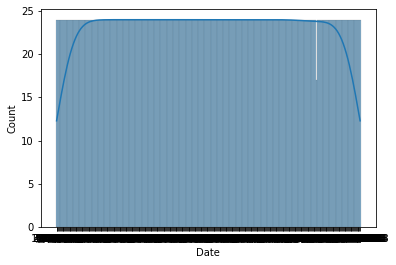

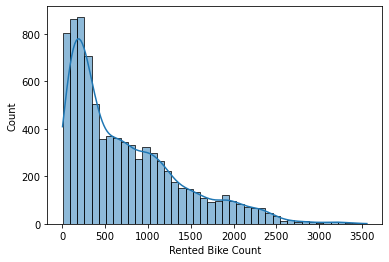

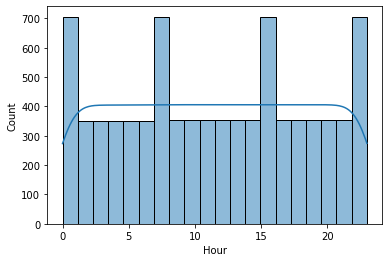

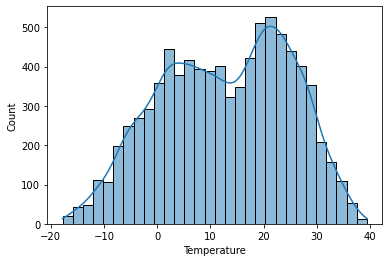

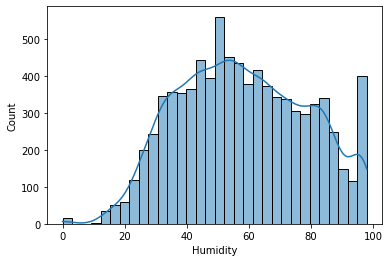

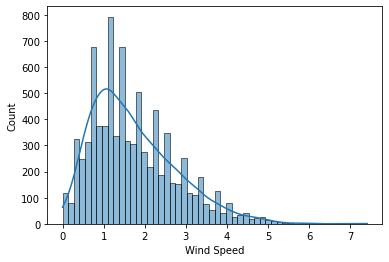

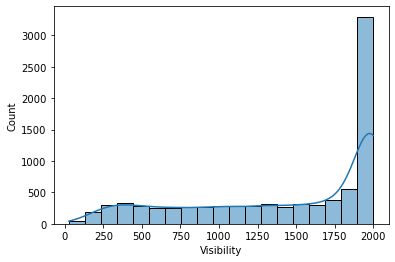

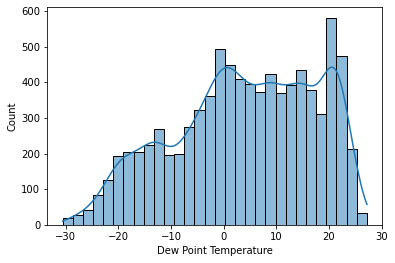

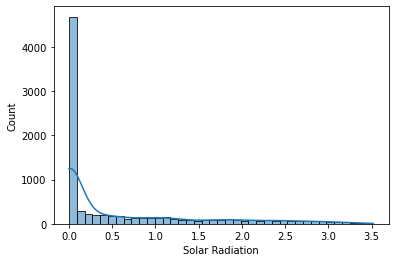

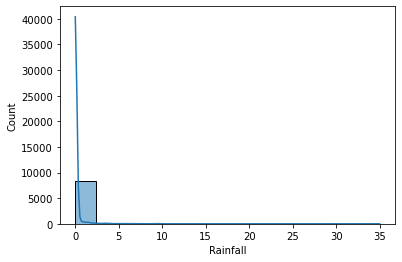

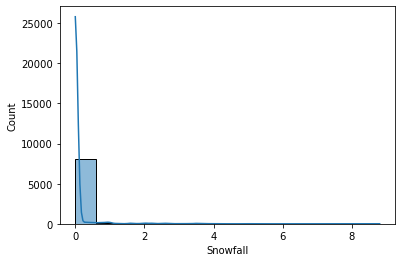

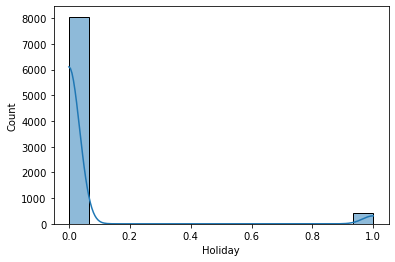

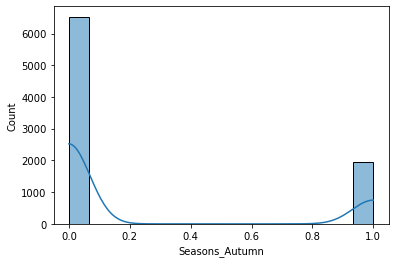

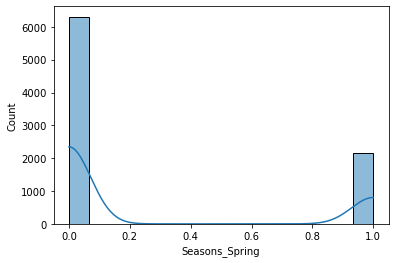

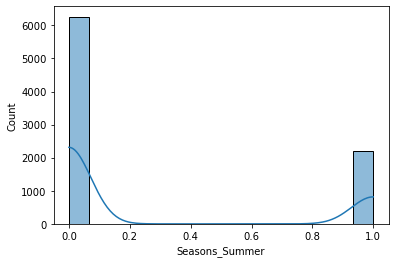

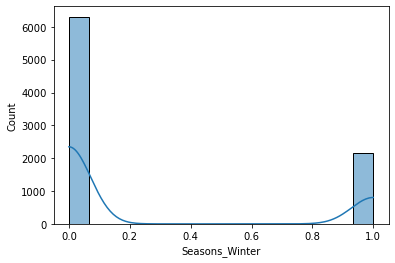

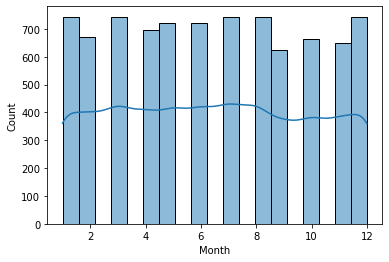

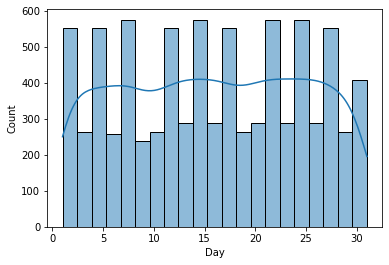

In [24]:
for column in bike_df:
    sns.histplot(bike_df[column], kde=True)
    plt.show()

### Investigate correlation of predictors & responses

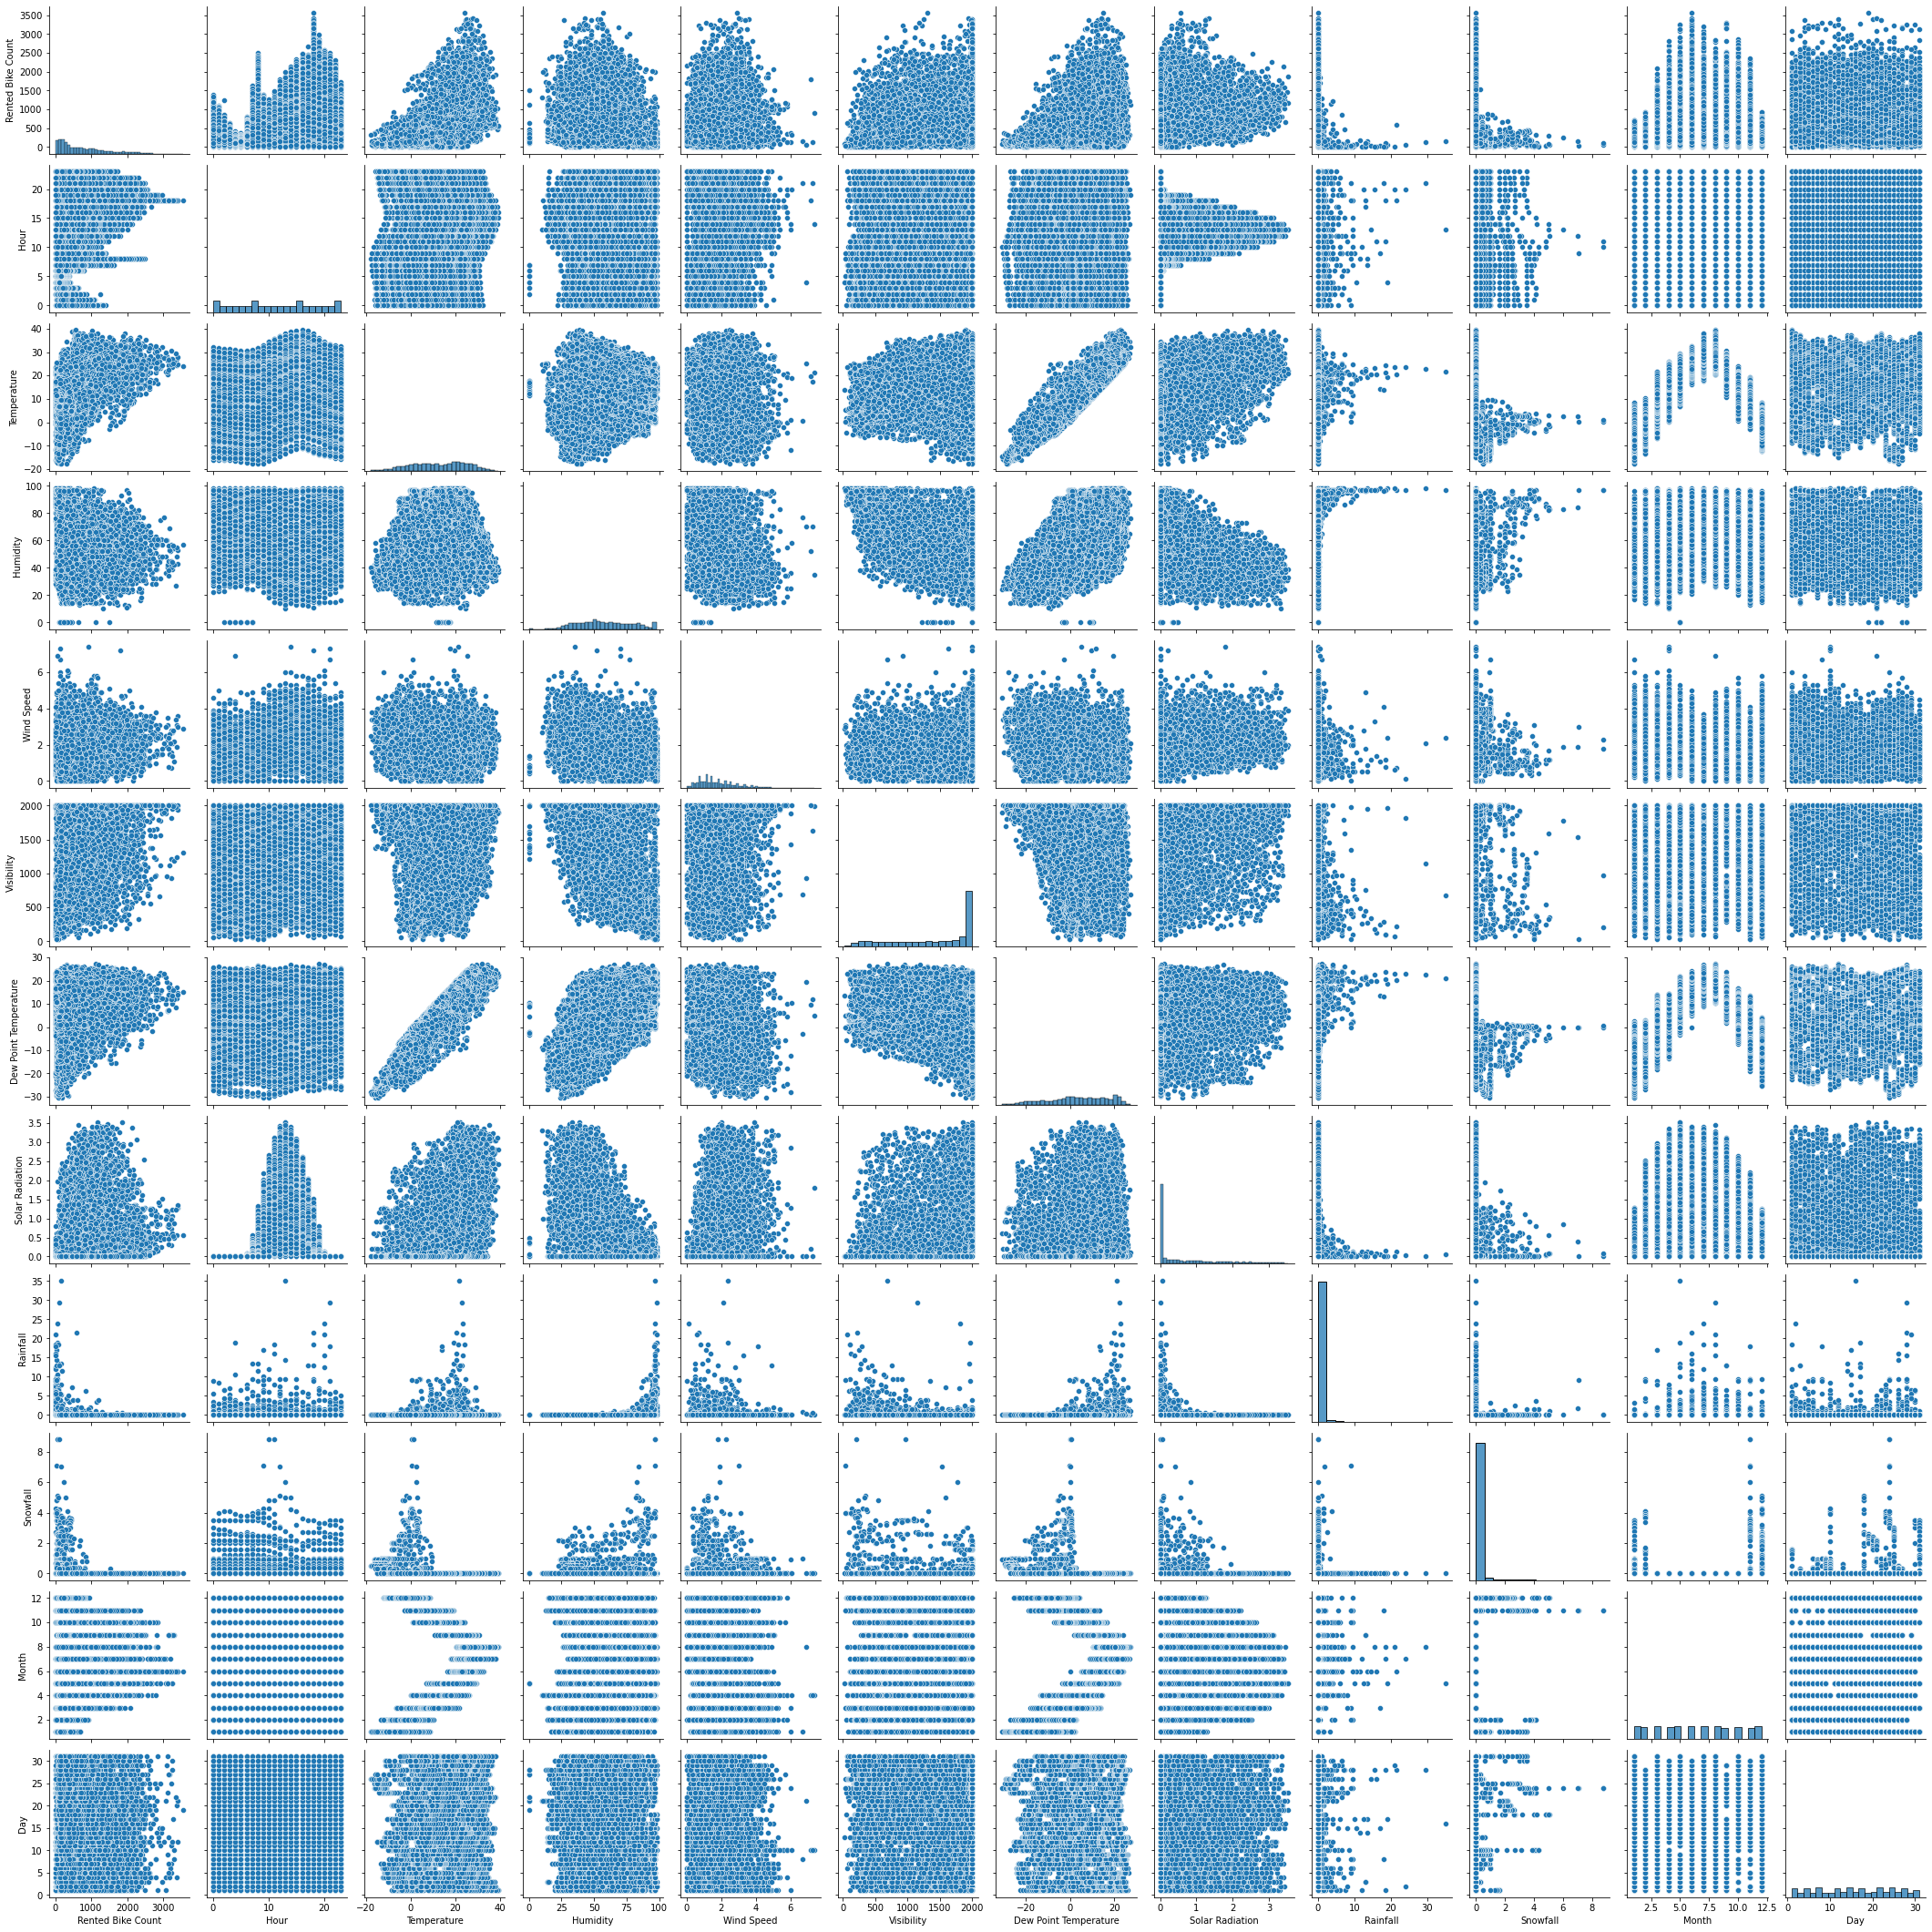

In [23]:
#Create pairwise plot for numerical predictors
sns.pairplot(bike_df, vars=['Rented Bike Count', 'Hour', 'Temperature', 'Humidity', 'Wind Speed', 
                            'Visibility', 'Dew Point Temperature', 'Solar Radiation', 'Rainfall', 
                            'Snowfall', 'Month', 'Day'])

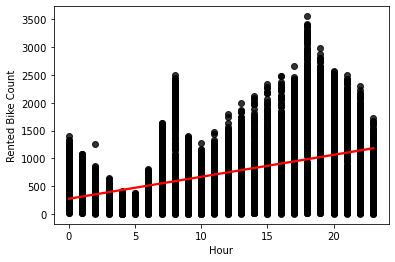

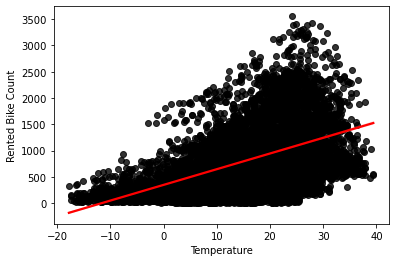

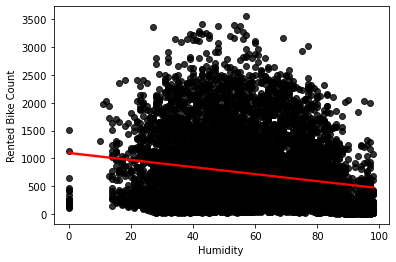

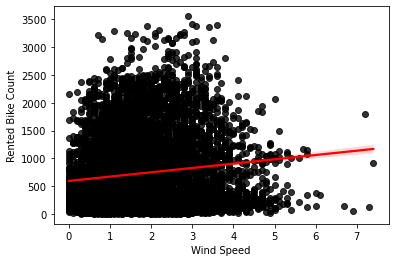

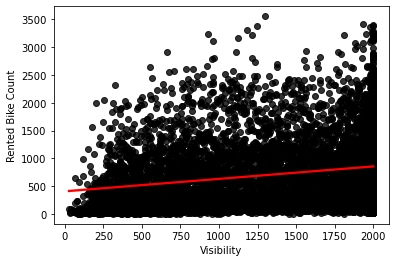

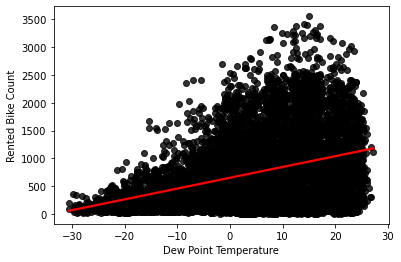

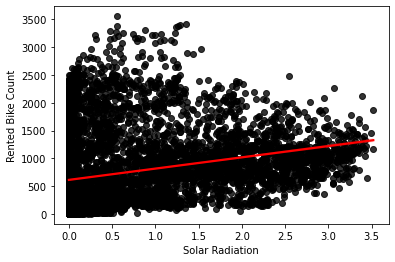

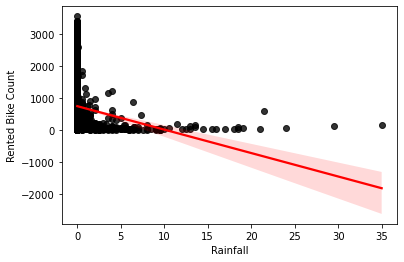

In [24]:
x_labels = bike_df.columns.drop(['Date', 'Rented Bike Count'])
for label in x_labels:
    sns.regplot(x=label, y='Rented Bike Count', data=bike_df, order=1, scatter_kws={"color": "black"}, line_kws={"color": "red"})
    plt.show()

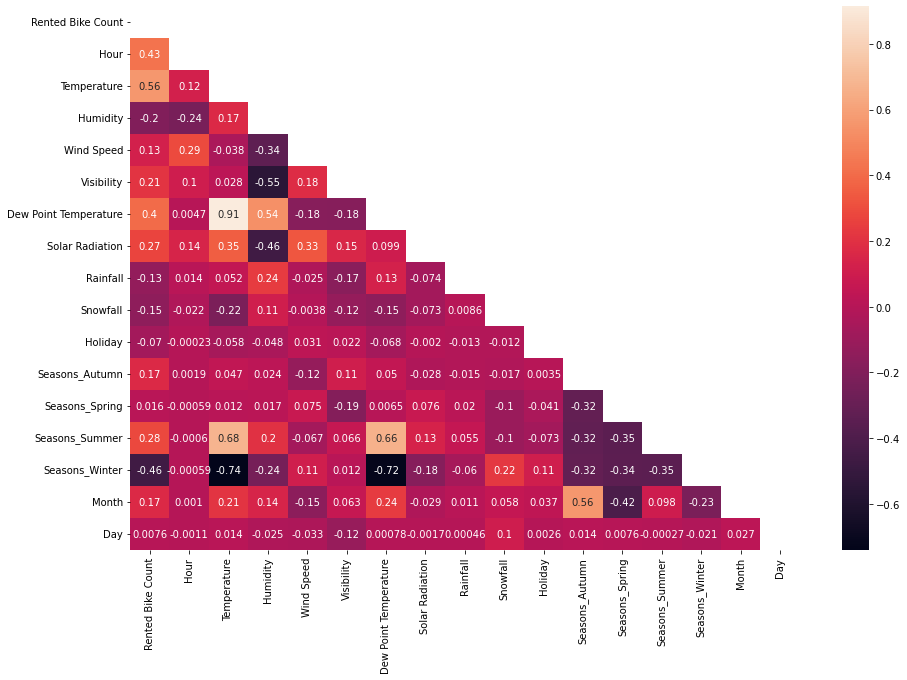

In [25]:
plt.figure(figsize=(15,10))
corr = bike_df.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(data=corr, annot=True, mask=mask)
#plt.savefig('./plot/heatmap.png', facecolor='w', bbox_inches='tight')
plt.show()

Very Positively Correlated (>=0.9): \
Temperature & Dew Point Temperature 

Positively Correlated (>=0.3): \
Rented Bike Count & Hour \
Rented Bike Count & Temperature \
Rented Bike Count & Dew Point Temperature \
Rented Bike Count & Seasons_Summer \
Temperature & Solar Radiation \
Temperature & Seasons_Summer \
Humidity & Dew Point Temperature \
Dew Point Temperature & Seasons_Summer \
Wind Speed & Solar Radiation 

Negatively Correlated (<=0.3): \
Rented Bike Count & Seasons_Winter \
Temperature & Seasons_Winter \
Humidity & Wind Speed \
Humidity & Visibility \
Humidity & Solar Radiation \
Dew Point Temperature & Seasons_Winter \

Omit Seasons vs Month

### Investigate distribution of Rented Bike Count

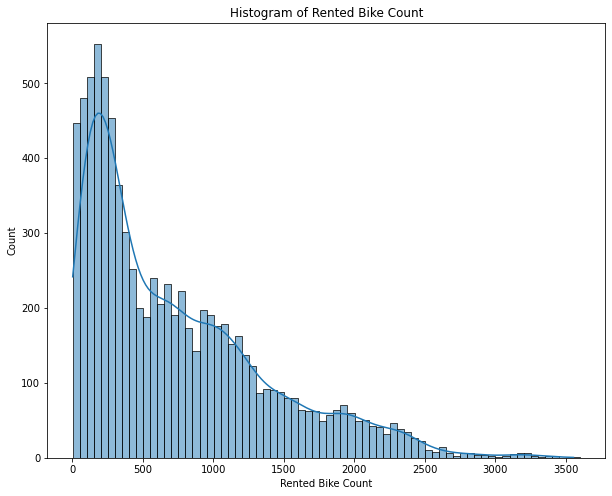

In [26]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)

sns.histplot(data=bike_df, x='Rented Bike Count', binwidth=50, kde=True)
plt.title('Histogram of Rented Bike Count')
#plt.savefig('./plot/y_hist.png', facecolor='w', bbox_inches='tight')
plt.show()

          Date  Rented Bike Count
0   2017-12-01               9539
1   2017-12-02               8523
2   2017-12-03               7222
3   2017-12-04               8729
4   2017-12-05               8307
..         ...                ...
348 2018-11-26              17162
349 2018-11-27              16282
350 2018-11-28              16524
351 2018-11-29              16423
352 2018-11-30              16297

[353 rows x 2 columns]


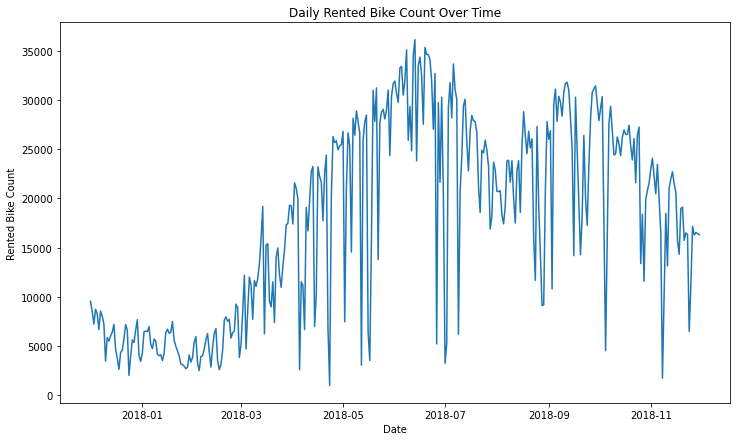

In [27]:
bike_df_copy = bike_df.copy()
bike_df_copy['Date'] = pd.to_datetime(bike_df['Date'], format='%d/%m/%Y')

bike_df_agg = bike_df_copy.groupby('Date')['Rented Bike Count'].sum().reset_index()
print(bike_df_agg)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1,1,1)

sns.lineplot(x='Date', y='Rented Bike Count', data=bike_df_agg)
plt.title('Daily Rented Bike Count Over Time')
#plt.savefig('./plot/y_line.png', facecolor='w', bbox_inches='tight')
plt.show()

## Create train and test dataset

### Create X and Y

In [28]:
X = bike_df.drop(columns=['Date', 'Rented Bike Count'])
Y = bike_df['Rented Bike Count'].values

### Standardize Numerical Predictors Using Z-score Standardization

In [29]:
#Split dummy variables out and only standardize numerical predictors
cat = ['Holiday', 'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter']
cat_df = X[cat]
num_df = X.drop(columns=cat)

#Use z-score standardization & join dummy variables back
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(num_df), columns=num_df.columns).join(cat_df)

### Split X & Y into train & test dataset

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y, test_size=0.20, random_state=1)

In [31]:
#Define 10-fold cross validation method
kf_10 = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

### Define Plot Function

In [32]:
#Function to plot regression plots
def reg_plots(Y_test, Y_pred, model_name, fig_name):
    #Plot graph of Y_test vs Y_pred
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    
    plt.scatter(Y_test, Y_pred, color='blue', alpha=0.5)
    plt.plot(Y_test, Y_test, color='black')
    plt.xlabel('Actual Rented Bike Count')
    plt.ylabel('Predicted Rented Bike Count')
    plt.title('Actual vs Predicted Rented Bike Count\n(' + model_name + ')')
    #plt.savefig('./model/y_vs_y_pred_' + fig_name + '.png', facecolor='w', bbox_inches='tight')
    plt.show()
    
    #Plot graph of Y_test vs residual
    residual = Y_test - Y_pred
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    
    plt.scatter(Y_test, residual, color='blue', alpha=0.5)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.xlabel('Actual Rented Bike Count')
    plt.ylabel('Residual')
    plt.title('Actual Rented Bike Count vs Residual\n(' + model_name + ')')
    #plt.savefig('./model/y_vs_err_' + fig_name + '.png', facecolor='w', bbox_inches='tight')
    plt.show()
    
    #Plot Q-Q plot
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    
    sm.qqplot(residual, ax=ax)
    #plt.savefig('./model/qq_plot_' + fig_name + '.png', facecolor='w', bbox_inches='tight')
    plt.show()
    
    #Plot histogram of Y_pred to verify
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    
    sns.histplot(data=Y_pred, binwidth=25, ax=ax)
    plt.title('Histogram of Predicted Rented Bike Count')
    #plt.savefig('./model/y_pred_hist_' + fig_name + '.png', facecolor='w', bbox_inches='tight')
    plt.show()
    
    #Plot histogram of residuals
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    
    sns.histplot(residual, ax=ax)
    plt.title('Histogram of Predicted Rented Bike Residuals')
    #plt.savefig('./model/resid_hist_' + fig_name + '.png', facecolor='w', bbox_inches='tight')
    plt.show()

## K-Nearest Neighbors Regression

In [33]:
def knn_regression(x_train, y_train, x_test, y_test, k):
    model = KNeighborsRegressor(n_neighbors = k, weights='distance')
    model = model.fit(x_train, y_train)
    pred = model.predict(x_test)
    output_rmse = mse(y_test, pred, squared=False)
    output_r2 = r2_score(y_test, pred)
    return model, pred, output_rmse, output_r2

Best K: 2
Test RMSE: 296.02055180070846
R squared: 0.7931939919301073


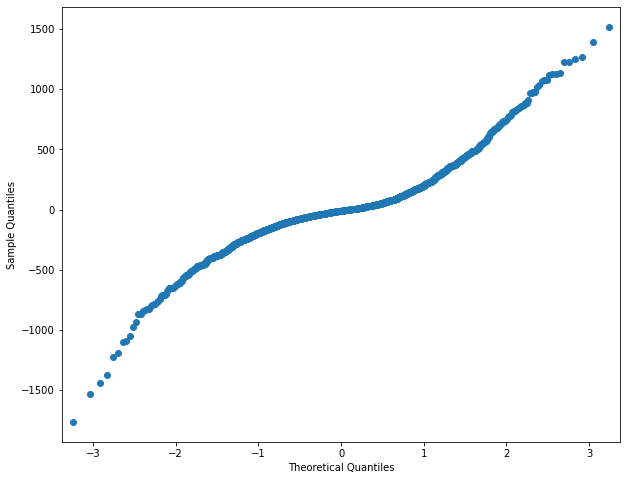

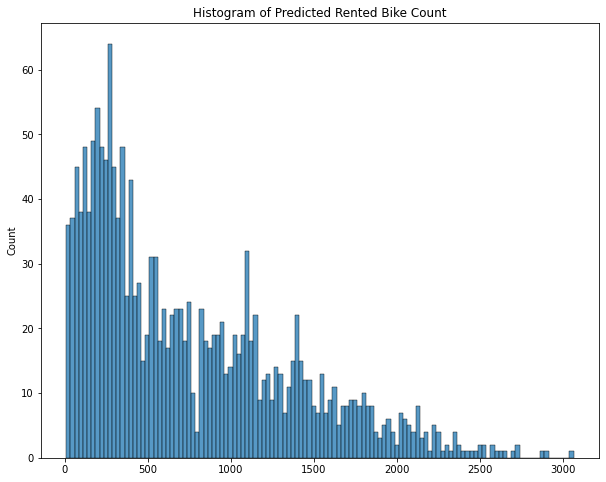

In [34]:
#Try K from 1 to 50
mse_list = []
k_range = range(1,51)
for K in k_range:
    _, _, model_mse, _ = knn_regression(X_train, Y_train, X_test, Y_test, K)
    mse_list.append(model_mse)
    
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
plt.plot(k_range, mse_list)
plt.title("Number of Neighbors vs MSE")
plt.xlabel("K")
plt.ylabel("MSE")
#plt.savefig('./model/k_vs_mse.png', facecolor='w', bbox_inches='tight') 
plt.show()

#Pick best K value and fit into model
best_k = mse_list.index(min(mse_list))
best_knn_model, best_knn_y_pred, best_knn_rmse, best_knn_r2 = knn_regression(X_train, Y_train, X_test, Y_test, best_k)

#Print results
print('Best K:', best_k)
print('Test RMSE:', best_knn_rmse)
print('R squared:', best_knn_r2)

#Plot graph
model_name = 'K-Nearest Neighbors Regression'
fig_name = 'knn'
reg_plots(Y_test, best_knn_y_pred, model_name, fig_name)

#### Note: Tested uniform weight / distance weight, stats below:
    Uniform:  K = 2, RMSE = 299.700, R2 = 0.788
    Distance: K = 2, RMSE = 296.021, R2 = 0.793

### Basic Linear Regression

In [35]:
#Function to run linear regression
def sm_ols(X_train, X_test, Y_train, Y_test, model_name, fig_name):
    #Fit model
    ols_model = sm.OLS(Y_train, X_train)
    ols_result = ols_model.fit()
    print(ols_result.summary())
    
    #Get results
    Y_pred = ols_result.predict(X_test)
    res_rmse = rmse(Y_test, Y_pred)
    r_sq = ols_result.rsquared
    print('Test RMSE:', res_rmse)
    print('R squared:', r_sq)
    print(durbin_watson(ols_result.resid))
    
    reg_plots(Y_test, Y_pred, model_name, fig_name)
    
    return res_rmse, r_sq

### 1. Linear regression with all predictors

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     534.3
Date:                Mon, 30 May 2022   Prob (F-statistic):               0.00
Time:                        21:25:13   Log-Likelihood:                -50718.
No. Observations:                6772   AIC:                         1.015e+05
Df Residuals:                    6756   BIC:                         1.016e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   591.73

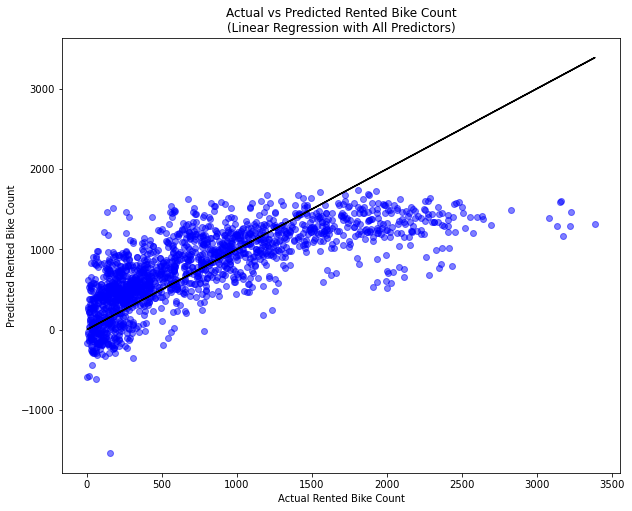

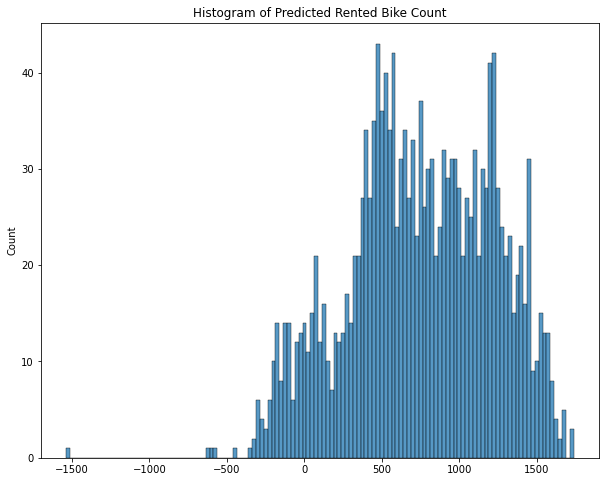

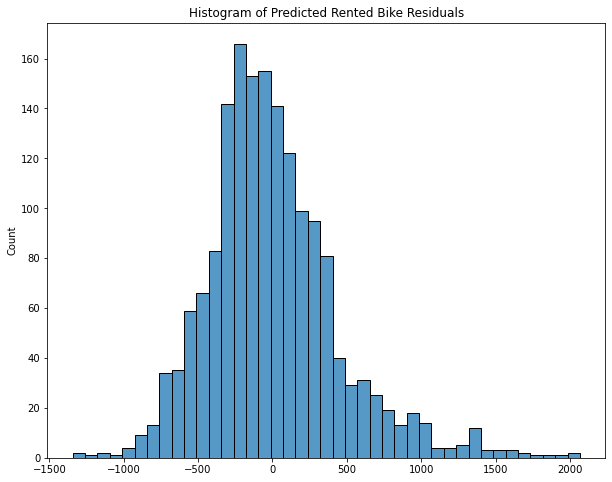

In [36]:
X_train_all = sm.add_constant(X_train)
X_test_all = sm.add_constant(X_test)
model_name = 'Linear Regression with All Predictors'
fig_name = 'linear_reg_all_x'
all_X_rmse, all_X_r_sq = sm_ols(X_train_all, X_test_all, Y_train, Y_test, model_name, fig_name)

Observation: The predicted Y are in normal distribution, but in reality it isn't.

### 2. Linear regression without unsignificant predictors from above model (p=0.05)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     667.1
Date:                Mon, 30 May 2022   Prob (F-statistic):               0.00
Time:                        21:25:14   Log-Likelihood:                -50721.
No. Observations:                6772   AIC:                         1.015e+05
Df Residuals:                    6759   BIC:                         1.016e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   591.89

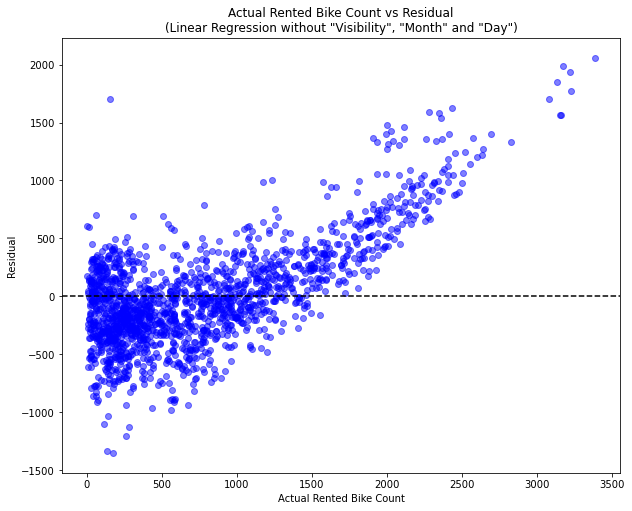

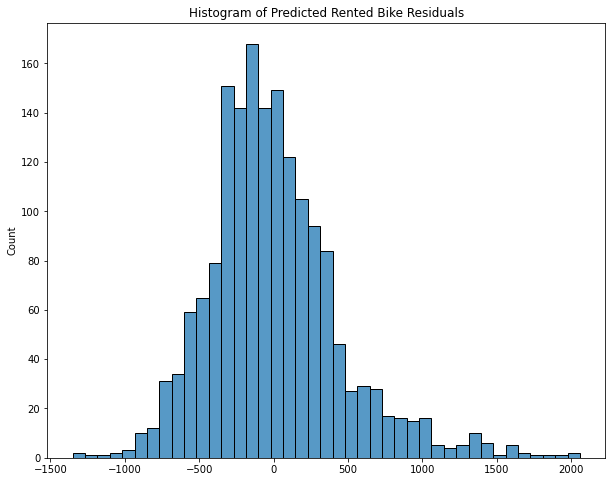

In [37]:
unsig_pred = ['Visibility', 'Month', 'Day']
X_train_sel = sm.add_constant(X_train.drop(columns=unsig_pred))
X_test_sel = sm.add_constant(X_test.drop(columns=unsig_pred))
model_name = 'Linear Regression without "Visibility", "Month" and "Day"'
fig_name = 'linear_reg_sel_x'
sel_X_rmse, sel_X_r_sq = sm_ols(X_train_sel, X_test_sel, Y_train, Y_test, model_name, fig_name)

### Dimension Reduction

### 1. PCR Model

Best M: 14


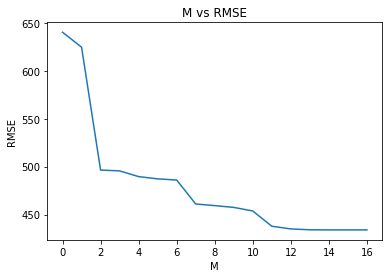

Test RMSE: 441.11581161809335
R2: 0.5407758972809552


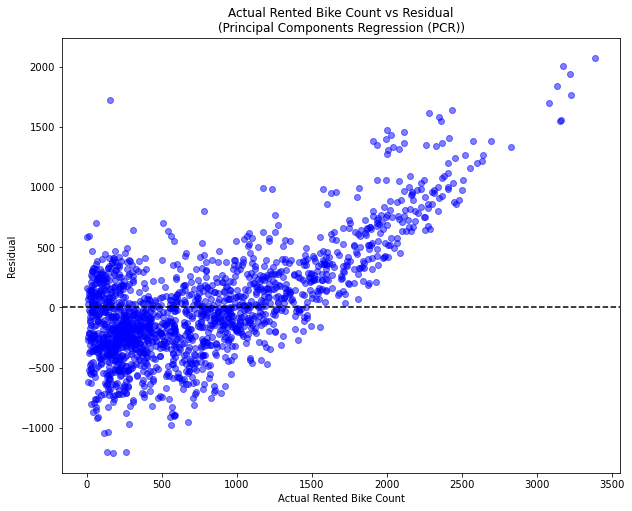

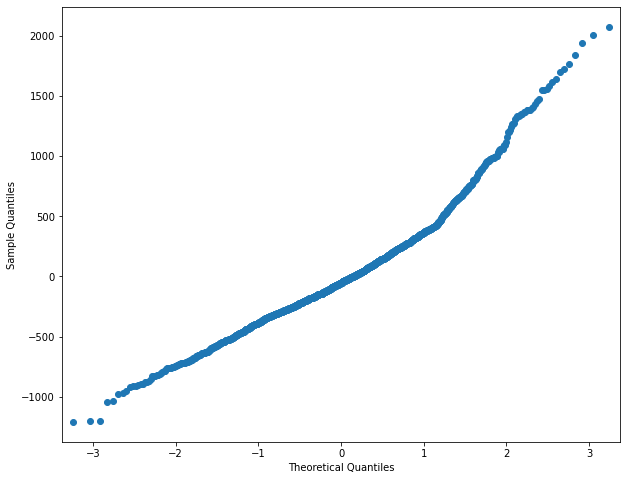

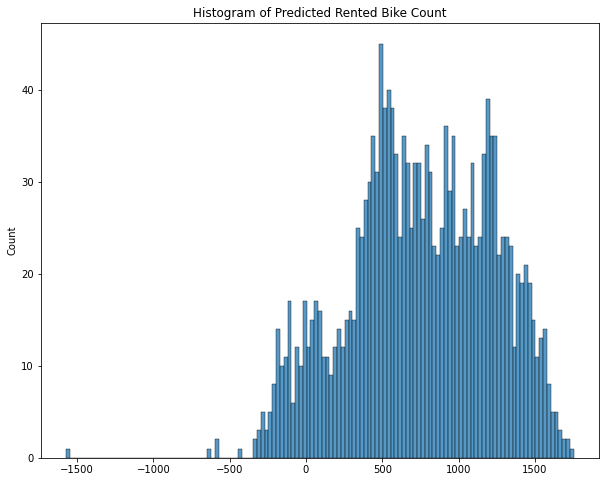

In [38]:
#Create model
pca = PCA()
X_train_reduced = pca.fit_transform(X_train)

regr = LinearRegression()
rmse_list = []

#Calculate RMSE with only the intercept
score = np.sqrt(-1*cross_val_score(regr,
                        np.ones((len(X_train_reduced),1)), Y_train, cv=kf_10,
                        scoring='neg_mean_squared_error').mean())
rmse_list.append(score)

#Calculate RMSE using cross-validation, adding one component at a time
for i in range(1, len(X_train.columns)+1):
    score = np.sqrt(-1*cross_val_score(regr,
                            X_train_reduced[:,:i], Y_train, cv=kf_10, scoring='neg_mean_squared_error').mean())
    rmse_list.append(score)
    
#Get values of best M
best_m = rmse_list.index(min(rmse_list))
print('Best M:', best_m)

#Plot M vs RMSE
plt.plot(range(0,len(X_train.columns)+1), rmse_list)
plt.xlabel('M')
plt.ylabel('RMSE')
plt.title('M vs RMSE')
#plt.savefig('./model/pcr_m.png', facecolor='w', bbox_inches='tight')
plt.show()

#Fit best M and test data into regression and obtain RMSE
X_test_reduced = pca.transform(X_test)

#Train regression model on training data 
regr = LinearRegression()
regr.fit(X_train_reduced[:,:best_m], Y_train)

#Prediction with test data
pcr_pred = regr.predict(X_test_reduced[:,:best_m])
pcr_rmse = mse(Y_test, pcr_pred, squared=False)
pcr_r2 = r2_score(Y_test, pcr_pred)
print('Test RMSE:', pcr_rmse)
print('R2:', pcr_r2)

model_name = 'Principal Components Regression (PCR)'
fig_name = 'pcr'
reg_plots(Y_test, pcr_pred, model_name, fig_name)

### 2. PLS Model

Best M: 10


RMSE: 441.1870659160518
R2: 0.5406275265674951


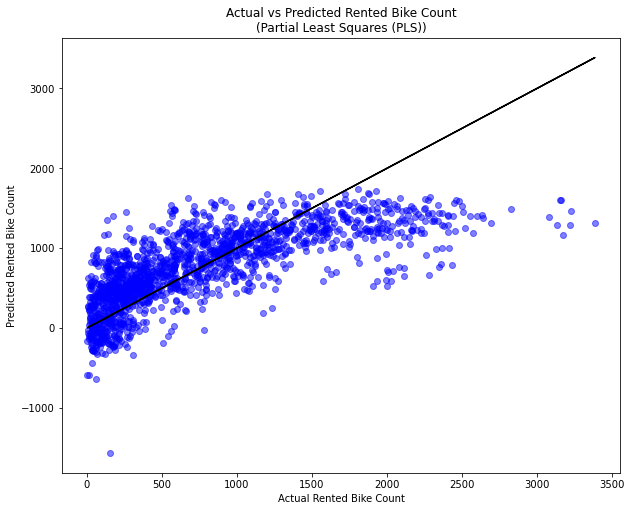

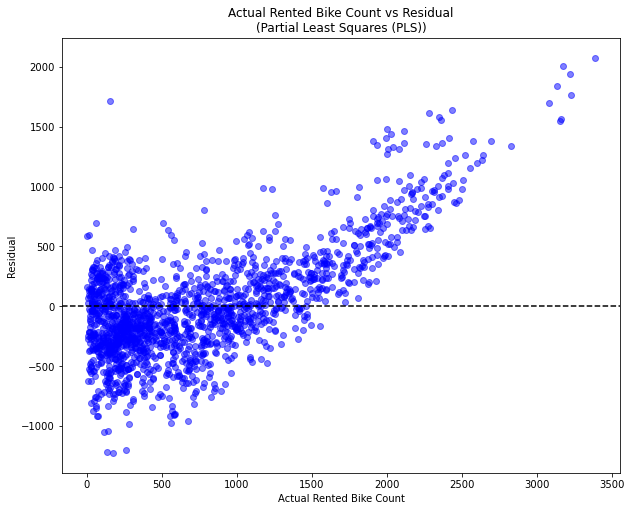

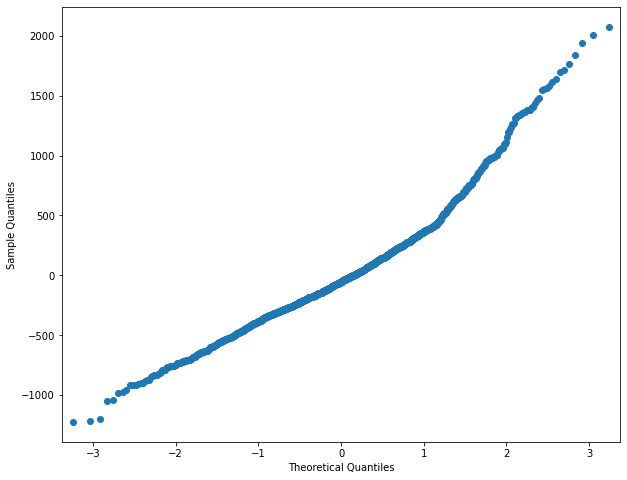

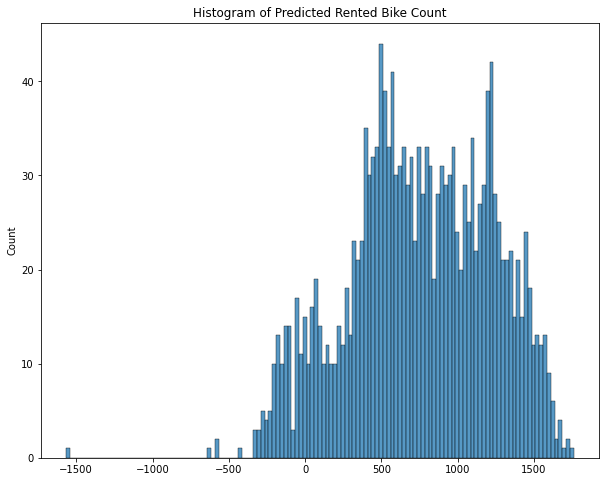

In [39]:
rmse_list = []

#Calculate RMSE using cross-validation, adding one component at a time
for i in range(1, len(X_train.columns)+1):
    pls = PLSRegression(n_components=i)
    score = np.sqrt(-1*cross_val_score(pls, X_train, Y_train, cv=kf_10, scoring='neg_mean_squared_error').mean())
    rmse_list.append(score)

#Get values of best M
best_m = rmse_list.index(min(rmse_list))+1
print('Best M:', best_m)

#Plot M vs RMSE
plt.plot(range(1,len(X_train.columns)), rmse_list[:-1])
plt.xlabel('M')
plt.ylabel('RMSE')
plt.title('M vs RMSE')
#plt.savefig('./pls_m.png', facecolor='w', bbox_inches='tight')
plt.show()

#Fit model with best M & predict test data
pls = PLSRegression(n_components=best_m)
pls.fit(X_train, Y_train)

pls_pred = pls.predict(X_test).reshape(-1,)
pls_rmse = mse(Y_test, pls_pred, squared=False)
pls_r2 = r2_score(Y_test, pls_pred)
print('RMSE:', pls_rmse)
print('R2:', pls_r2)

model_name = 'Partial Least Squares (PLS)'
fig_name = 'pls'
reg_plots(Y_test, pls_pred, model_name, fig_name)

## Polynomial Regression

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

In [41]:
def poly_reg(attr, deg):
    statement = 'Q("Rented Bike Count") ~ ' + attr
    if deg == 2:
        statement = statement + ' + I(' + attr + '**2)'
    elif deg == 3:
        statement = statement + ' + I(' + attr + '**2) + I(' + attr + '**3)'
    elif deg == 4:
        statement = statement + ' + I(' + attr + '**2) + I(' + attr + '**3) + I(' + attr + '**4)'
    poly_model = smf.ols(statement, data=bike_df)
    poly_result = poly_model.fit()
    print(poly_result.summary())

    #Get results
    Y_pred = poly_result.predict(X_test[attr])
    res_rmse = rmse(Y_test, Y_pred)
    r_sq = poly_result.rsquared
    print('Test RMSE:', res_rmse)
    print('R squared:', r_sq)

    model_name = 'Degree-' + str(deg) + 'Polynomial Regression using ' + attr
    fig_name = 'poly_' + attr
    reg_plots(Y_test, Y_pred, model_name, fig_name)

    new_attr = np.linspace(bike_df[attr].min(), bike_df[attr].max(), num=100)
    predictions = poly_result.predict({attr: new_attr})
    _, data, _ = summary_table(poly_result, alpha=0.05)
    predicted_mean_ci_low, predicted_mean_ci_high = data[:, 4:6].T
    plt.figure(figsize=(10, 8))
    plt.scatter(bike_df[attr], bike_df['Rented Bike Count'], facecolors='none', edgecolors='gray', label="data")
    plt.plot(new_attr, predictions, 'r-', label='Prediction')
    order = np.argsort(bike_df[attr].values)
    plt.plot(bike_df[attr].values[order], predicted_mean_ci_low[order], 'r--', label='95% CI')
    plt.plot(bike_df[attr].values[order], predicted_mean_ci_high[order], 'r--')
    plt.legend(loc='best')
    plt.xlabel(attr)
    plt.ylabel('Rented Bike Count')
    plt.title('Scatter Plot of ' + attr + ' vs Rented Bike Count with Polynomial Regression Line')
    #plt.savefig('./model/scatter_with_poly_line_' + attr + '.png', facecolor='w', bbox_inches='tight')
    plt.show()
    
    return res_rmse, r_sq

                              OLS Regression Results                              
Dep. Variable:     Q("Rented Bike Count")   R-squared:                       0.236
Model:                                OLS   Adj. R-squared:                  0.235
Method:                     Least Squares   F-statistic:                     652.5
Date:                    Mon, 30 May 2022   Prob (F-statistic):               0.00
Time:                            21:25:28   Log-Likelihood:                -65600.
No. Observations:                    8465   AIC:                         1.312e+05
Df Residuals:                        8460   BIC:                         1.312e+05
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercep

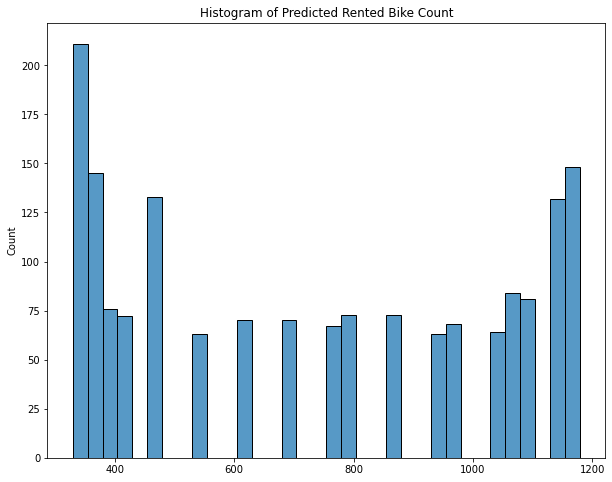

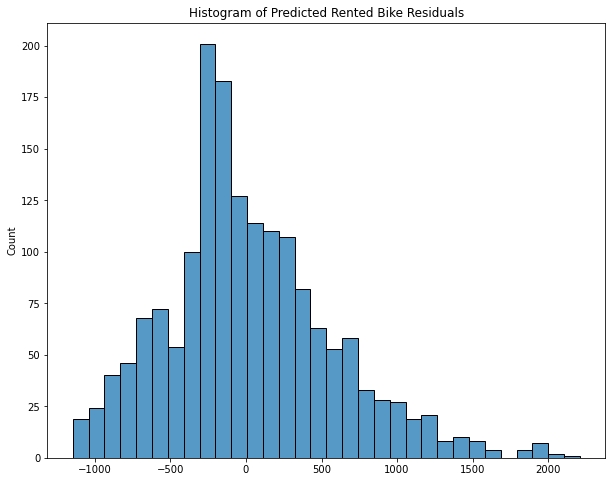

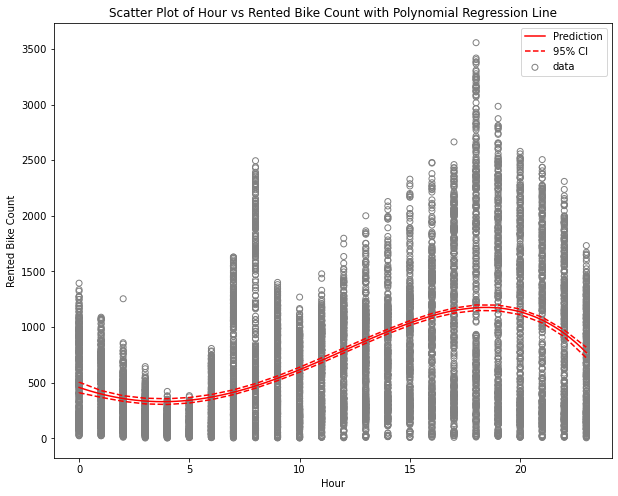

In [42]:
poly_hour_rmse, poly_hour_r2 = poly_reg('Hour', 4)

                              OLS Regression Results                              
Dep. Variable:     Q("Rented Bike Count")   R-squared:                       0.340
Model:                                OLS   Adj. R-squared:                  0.339
Method:                     Least Squares   F-statistic:                     1087.
Date:                    Mon, 30 May 2022   Prob (F-statistic):               0.00
Time:                            21:25:30   Log-Likelihood:                -64983.
No. Observations:                    8465   AIC:                         1.300e+05
Df Residuals:                        8460   BIC:                         1.300e+05
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

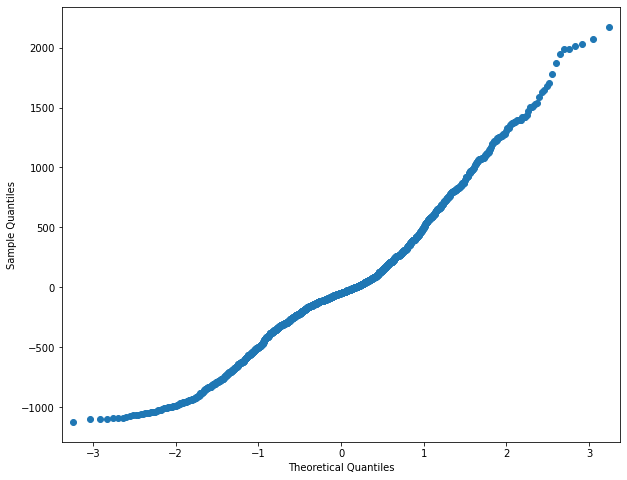

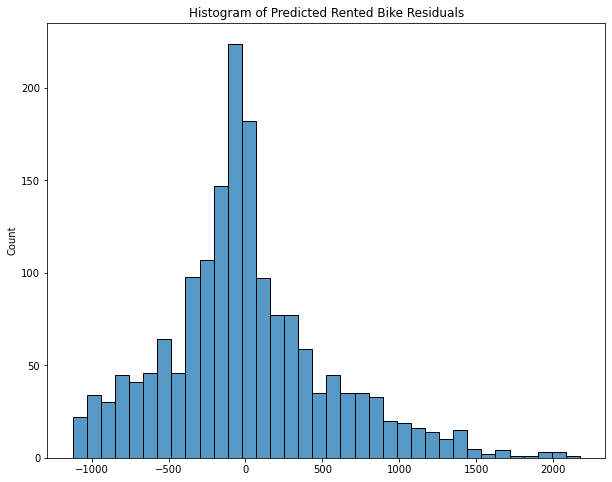

In [43]:
poly_temp_rmse, poly_temp_r2 = poly_reg('Temperature', 4)

## SVM Regression

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y, test_size=0.20, random_state=1)

In [45]:
svr = SVR(kernel='rbf')
c_space = np.array([0.001, 0.01, 0.1, 1])
g_space = np.array([1,0.1,0.01,0.001])
param_grid = {'C': c_space, 'gamma': g_space}
scorer = make_scorer(mse, greater_is_better=False)
tune = GridSearchCV(svr, param_grid, cv=5, scoring=scorer)
tune.fit(X_train, Y_train)
print(tune.best_params_)

{'C': 1.0, 'gamma': 0.1}


RMSE: 532.279940174149
R2: 0.33134880868523475


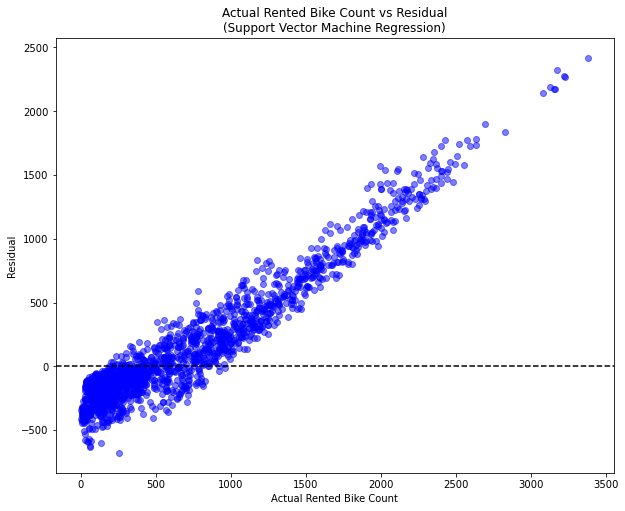

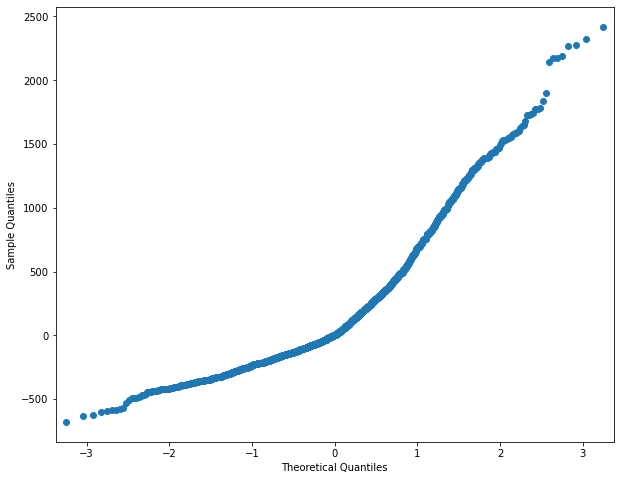

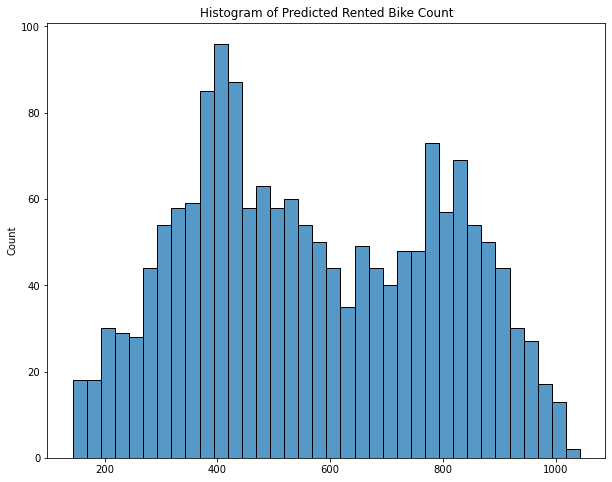

In [46]:
regressor = SVR(kernel = 'rbf', C=1, gamma=0.1)
regressor.fit(X_train, Y_train)
svr_pred = regressor.predict(X_test)
svr_rmse = mse(Y_test, svr_pred, squared=False)
svr_r2 = r2_score(Y_test, svr_pred)

print('RMSE:', svr_rmse)
print('R2:', svr_r2)

model_name = 'Support Vector Machine Regression'
fig_name = 'svr'
reg_plots(Y_test, svr_pred, model_name, fig_name)

For reference: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html

### Conclusion Table

In [47]:
results = {'Linear Regression (All predictors)':  [all_X_rmse, all_X_r_sq],
           'Linear Regression (Selected predictors)': [sel_X_rmse, sel_X_r_sq],
           'PCR': [pcr_rmse, pcr_r2],
           'PLS': [pls_rmse, pls_r2],
           'KNN': [best_knn_rmse, best_knn_r2],
           'Polynomial Regression (Hour)': [poly_hour_rmse, poly_hour_r2],
           'Polynomial Regression (Temperature)': [poly_temp_rmse, poly_temp_r2],
           'SVM': [svr_rmse, svr_r2]
        }

results_df = pd.DataFrame(results, index=['RMSE', 'R Square'])

In [48]:
results_df

Linear Regression (All predictors)  \
RMSE                              441.725382   
R Square                            0.542596   

          Linear Regression (Selected predictors)         PCR         PLS  \
RMSE                                   441.883267  441.115812  441.187066   
R Square                                 0.542218    0.540776    0.540628   

                 KNN  Polynomial Regression (Hour)  \
RMSE      296.020552                    557.075693   
R Square    0.793194                      0.235761   

          Polynomial Regression (Temperature)         SVM  
RMSE                               536.565602  532.279940  
R Square                             0.339515    0.331349

In [49]:
#Save the above table as png
import dataframe_image as dfi

#dfi.export(results_df, './results.png')